# Sequence-to-sequence activity recognition

In [2]:
from tensorflow.keras.layers import (
    Add,
    Dense,
    Dropout,
    MultiHeadAttention,
    LayerNormalization,
    Layer,
    Normalization,
)
from tensorflow.keras import Model
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os

## Layer

In [3]:
class PositionalEmbedding(Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units

        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))

        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        x = self.projection(inputs)
        x = x + self.position

        return self.dropout(x, training=training)


In [5]:
class Encoder(Layer):
    def __init__(
        self,
        embed_dim,
        mlp_dim,
        num_heads,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        self.mha = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=attention_dropout_rate,
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )

        self.dense_0 = Dense(
            units=mlp_dim,
            activation="gelu",
            kernel_initializer=TruncatedNormal(stddev=0.02),
        )
        self.dense_1 = Dense(
            units=embed_dim, kernel_initializer=TruncatedNormal(stddev=0.02)
        )

        self.dropout_0 = Dropout(rate=dropout_rate)
        self.dropout_1 = Dropout(rate=dropout_rate)

        self.norm_0 = LayerNormalization(epsilon=1e-5)
        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.add_0 = Add()
        self.add_1 = Add()

    def call(self, inputs, training):
        # Attention block
        x = self.norm_0(inputs)
        x, attn = self.mha(
            query=x,
            value=x,
            key=x,
            return_attention_scores=True,
            training=training,
        )
        x = self.dropout_0(x, training=training)
        x = self.add_0([x, inputs])

        # MLP block
        y = self.norm_1(x)
        y = self.dense_0(y)
        y = self.dense_1(y)
        y = self.dropout_1(y, training=training)

        return self.add_1([x, y]), attn


## Model

In [6]:
class Transformer(Model):
    def __init__(
        self,
        num_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_classes,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm = Normalization()

        # Input
        self.pos_embs = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.e_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_layers)
        ]

        # Output
        self.norm = LayerNormalization(epsilon=1e-5)
        self.final_layer = Dense(num_classes, kernel_initializer="zeros")

    def call(self, inputs, training):
        x = self.input_norm(inputs)
        x = self.pos_embs(x, training=training)

        for layer in self.e_layers:
            x, attn = layer(x, training=training)

        x = self.norm(x)
        x = self.final_layer(x)

        return x, attn


## Dataset

In [7]:
def load_data(type):
    TRAINING_PATH = '../data/every_5s_mini/train/'
    VAL_PATH = '../data/every_5s/validate/'
    TEST_PATH = '../data/every_5s/test/'
    POS = 'Hand'
    FILENAME_ACC = "Acc_every_5s.npy"
    FILENAME_GYR = "Gyr_every_5s.npy"
    FILENAME_MAG = "Mag_every_5s.npy"
    FILENAME_LABEL = 'Label_every_5s.npy'
    TYPE = ['train','test','validate']
    if type == 'train':
        dir = TRAINING_PATH
    elif type == 'validate':
        dir = VAL_PATH
    elif type == 'test':
        dir = TEST_PATH
    else:
        print('type is not valid.')
        return
    acc = np.load(os.path.join(dir,POS,FILENAME_ACC))[:,:,1:]
    gyr = np.load(os.path.join(dir,POS,FILENAME_GYR))[:,:,1:]
    mag = np.load(os.path.join(dir,POS,FILENAME_MAG))[:,:,1:]
    y = np.load(os.path.join(dir,FILENAME_LABEL))[:,:,1:].squeeze().astype('uint8')-1 if type != 'test' else None
    X = np.concatenate([acc,gyr,mag],axis=2).astype('float32')
    # print(X.shape,y.shape)
    return X,y

In [11]:

CLASS_LABELS = np.array(
    ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
)

# load dataset
# X_train,y_train = load_data('train')
X_test,y_test = load_data('validate')
# print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# print(X_val.shape, y_val.shape)
# print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# print(X_val.shape, y_val.shape)


(21650, 500, 9) (21650, 500)
(21650, 500, 9) (21650, 500)


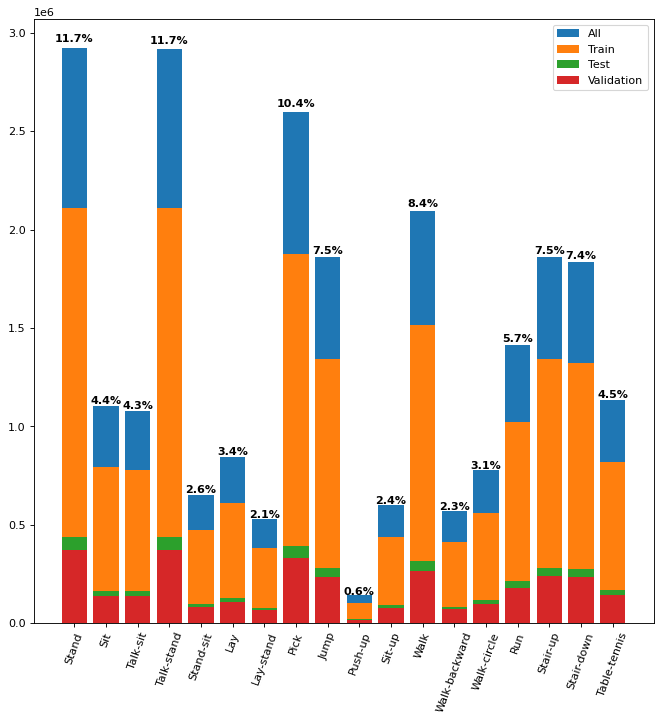

In [ ]:
plt.figure(figsize=(10, 10), dpi=80)

total_counts = labels.shape[0] * labels.shape[1]
unique, all_counts = np.unique(labels, return_counts=True)
chart = plt.bar(CLASS_LABELS[unique], all_counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

unique, counts = np.unique(y_val, return_counts=True)
plt.bar(CLASS_LABELS[unique], counts)
plt.xticks(rotation=70)

for i, p in enumerate(chart):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(
        x + width / 2,
        y + height * 1.01,
        str(round((all_counts[i] * 100) / total_counts, 1)) + "%",
        ha="center",
        weight="bold",
    )

plt.legend(["All", "Train", "Test", "Validation"])
plt.show()


## Create model

In [12]:
class config:
  epochs=50
  num_layers=3
  # embed_layer_size=96
  embed_layer_size=128
  fc_layer_size=256
  # num_heads=6
  num_heads=5
  dropout=0.1
  attention_dropout=0.1
  optimizer='adamw'
  amsgrad=False
  label_smoothing=0.1
  learning_rate=1e-3
  weight_decay=5e-5
  warmup_steps=10
  batch_size=32
  global_clipnorm=3.0

In [10]:
# Generate new model
model = Transformer(
    num_layers=config.num_layers,
    embed_dim=config.embed_layer_size,
    mlp_dim=config.fc_layer_size,
    num_heads=config.num_heads,
    num_classes=8,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
)


(1, 500, 8) (1, 5, 500, 500)


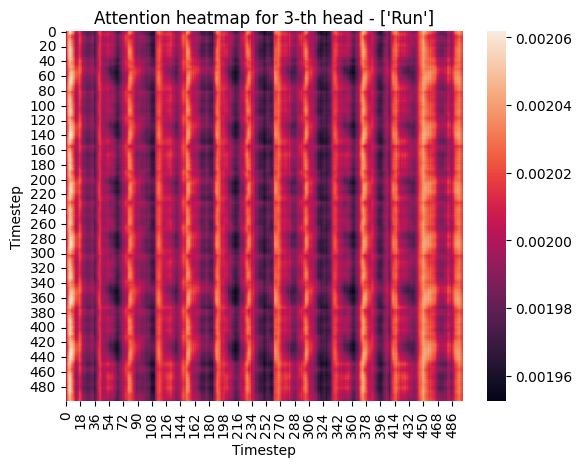

In [14]:
batch_id = 20

out, attn = model(tf.expand_dims(X_test[batch_id], axis=0))
print(out.shape, attn.shape)

for i in range(attn.shape[1]):
    plt.figure()
    ax = sns.heatmap(attn[0, i])
    ax.set_title(
        f"Attention heatmap for {i}-th head - {CLASS_LABELS[np.unique(y_test[batch_id])]}"
    )
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Timestep")



## Visualize position

Text(50.722222222222214, 0.5, 'Timestep')

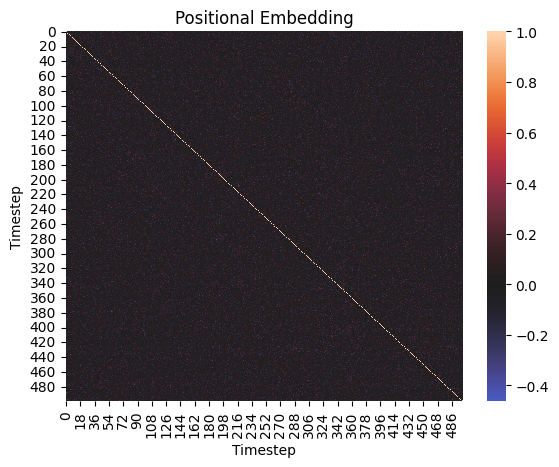

In [16]:
similarity_scores = np.dot(
    model.pos_embs.position[0], np.transpose(model.pos_embs.position[0])
) / (
    np.linalg.norm(model.pos_embs.position[0], axis=-1)
    * np.linalg.norm(model.pos_embs.position[0], axis=-1)
)


plt.figure()
ax = sns.heatmap(similarity_scores, center=0)
ax.set_title("Positional Embedding")
ax.set_xlabel("Timestep")
ax.set_ylabel("Timestep")


In [39]:
model.summary()


Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  multiple                 19        
 n)                                                              
                                                                 
 positional_embedding (Posit  multiple                 65280     
 ionalEmbedding)                                                 
                                                                 
 encoder (Encoder)           multiple                  396160    
                                                                 
 encoder_1 (Encoder)         multiple                  396160    
                                                                 
 encoder_2 (Encoder)         multiple                  396160    
                                                                 
 layer_normalization_6 (Laye  multiple                 

## Load trained model

In [18]:
model.load_weights("../output/model/transformer/0601/cp-0015.ckpt")




(1, 500, 8) (1, 5, 500, 500)


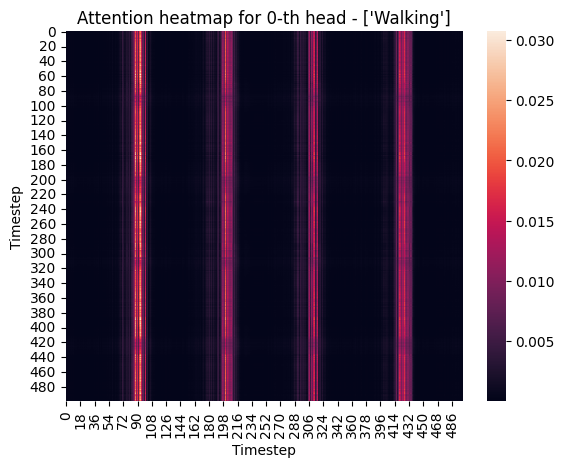

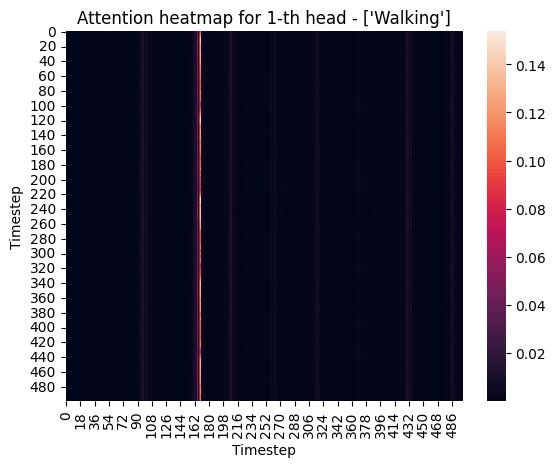

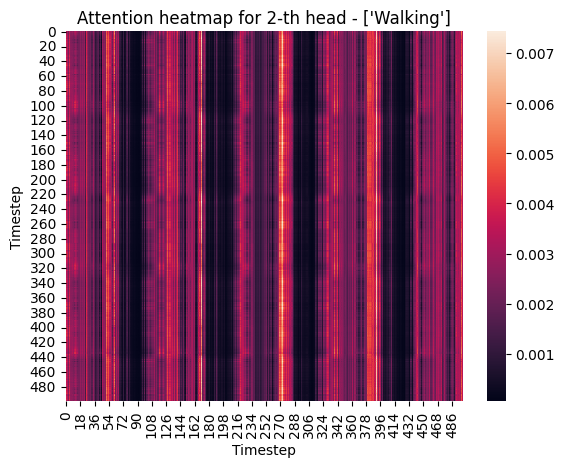

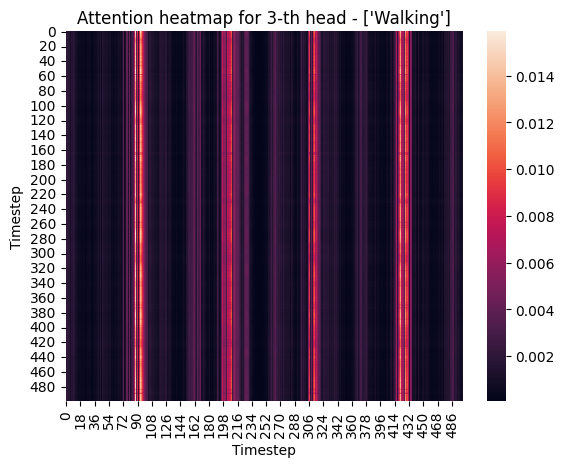

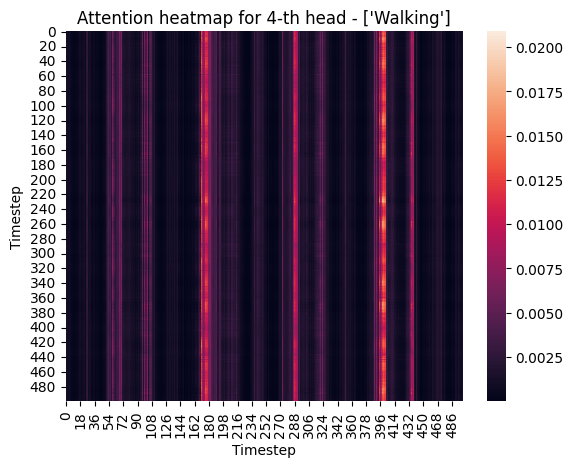

In [19]:
batch_id = 75

out, attn = model(tf.expand_dims(X_test[batch_id], axis=0))
print(out.shape, attn.shape)

for i in range(attn.shape[1]):
    plt.figure()
    ax = sns.heatmap(attn[0, i])
    ax.set_title(
        f"Attention heatmap for {i}-th head - {CLASS_LABELS[np.unique(y_test[batch_id])]}"
    )
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Timestep")


## Visualize position

Text(50.722222222222214, 0.5, 'Timestep')

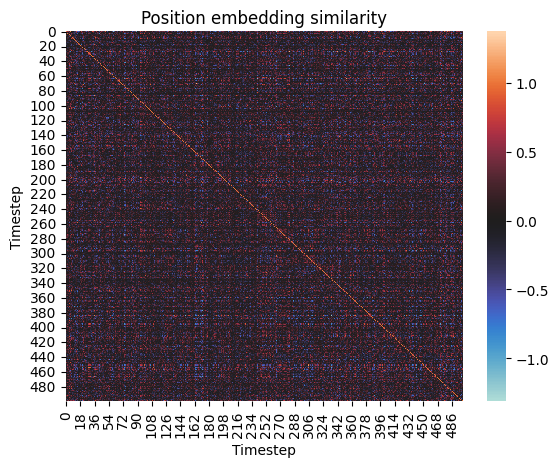

In [20]:
similarity_scores = np.dot(
    model.pos_embs.position[0], np.transpose(model.pos_embs.position[0])
) / (
    np.linalg.norm(model.pos_embs.position[0], axis=-1)
    * np.linalg.norm(model.pos_embs.position[0], axis=-1)
)


plt.figure()
ax = sns.heatmap(similarity_scores, center=0)
ax.set_title("Position embedding similarity")
ax.set_xlabel("Timestep")
ax.set_ylabel("Timestep")


In [22]:
def get_predictions(start, end):
    out, attn = model(X_test[start:end])
    predictions = np.argmax(out, axis=-1)

    return predictions, attn


batch_size = 64  # set it by your GPU size

full_predictions = []
for i in range(X_test.shape[0] // batch_size):
    y, _ = get_predictions(i * batch_size, (i + 1) * batch_size)
    full_predictions.append(y)

y, attn = get_predictions((i + 1) * batch_size, X_test.shape[0])
full_predictions.append(y)

full_predictions = np.concatenate(full_predictions, axis=0)
print(full_predictions.shape)

full_predictions = full_predictions.reshape(-1, full_predictions.shape[-1])
print(full_predictions.shape)


(21650, 500)
(21650, 500)


## Confusion Matrix

In [37]:
class_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']

def plot_confusion_matrix(test_y,pred_y,class_names,normalize=True, fontsize=16, vmin=0, vmax=1, axis=1):
    cm = (confusion_matrix(test_y,pred_y))
    # classes = class_names[unique_labels(test_y,pred_y)]
    if normalize:
        cm_rate = cm.astype('float') / cm.sum(axis=axis, keepdims=True)
    
    if len(class_names) <= 3:
        fig, ax = plt.subplots(figsize=(8, 4))
    else:
        fig, ax = plt.subplots(figsize=(16, 8))

    im = ax.imshow(cm_rate, interpolation='nearest', cmap=plt.cm.Blues, vmin=vmin, vmax=vmax)
#     ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    ax.set_ylabel('True label\n', fontsize=fontsize)
    ax.set_xlabel('\nPredicted label', fontsize=fontsize)
    ax.set_xticklabels(class_names, fontsize=fontsize)
    ax.set_yticklabels(class_names, fontsize=fontsize)
    
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm_rate[i, j] * 100, fmt),
                    ha="center",
                    va="center",
                    color="white" if cm_rate[i, j] > 0.5 else 'black', fontsize=fontsize)
            ax.text(j, i+0.3, '( ' + str(cm[i, j]) + ' )', ha="center",
                    va="center",
                    color="white" if cm_rate[i, j] > 0.5 else 'black', fontsize=fontsize//2)
    fig.tight_layout()
    
    # print(f1_score(test_y, pred_y, average='macro'))
    print(classification_report(test_y, pred_y))
    return ax

In [32]:
full_predictions.shape,y_test.shape

((21650, 500), (21650, 500))

              precision    recall  f1-score   support

           0       0.54      0.77      0.63   2127000
           1       0.86      0.76      0.81   1896000
           2       0.27      0.90      0.42     59500
           3       0.81      0.57      0.67    964000
           4       0.49      0.08      0.13   1541000
           5       0.09      0.24      0.13    644000
           6       0.41      0.20      0.27   1425500
           7       0.52      0.62      0.57   2168000

    accuracy                           0.52  10825000
   macro avg       0.50      0.52      0.45  10825000
weighted avg       0.56      0.52      0.50  10825000



<Axes: xlabel='\nPredicted label', ylabel='True label\n'>

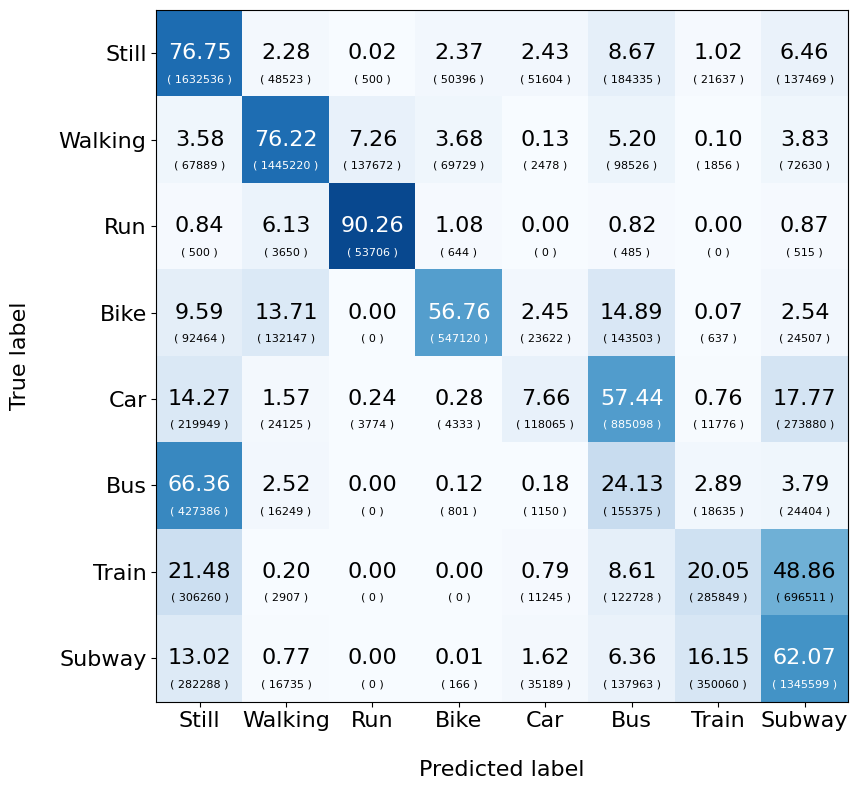

In [38]:
plot_confusion_matrix(y_test.reshape(-1),full_predictions.reshape(-1),class_names=CLASS_LABELS)

              precision    recall  f1-score   support

       Still      0.539     0.768     0.633   2127000
     Walking      0.855     0.762     0.806   1896000
         Run      0.274     0.903     0.421     59500
        Bike      0.813     0.568     0.668    964000
         Car      0.485     0.077     0.132   1541000
         Bus      0.090     0.241     0.131    644000
       Train      0.414     0.201     0.270   1425500
      Subway      0.522     0.621     0.567   2168000

    accuracy                          0.516  10825000
   macro avg      0.499     0.517     0.454  10825000
weighted avg      0.563     0.516     0.503  10825000



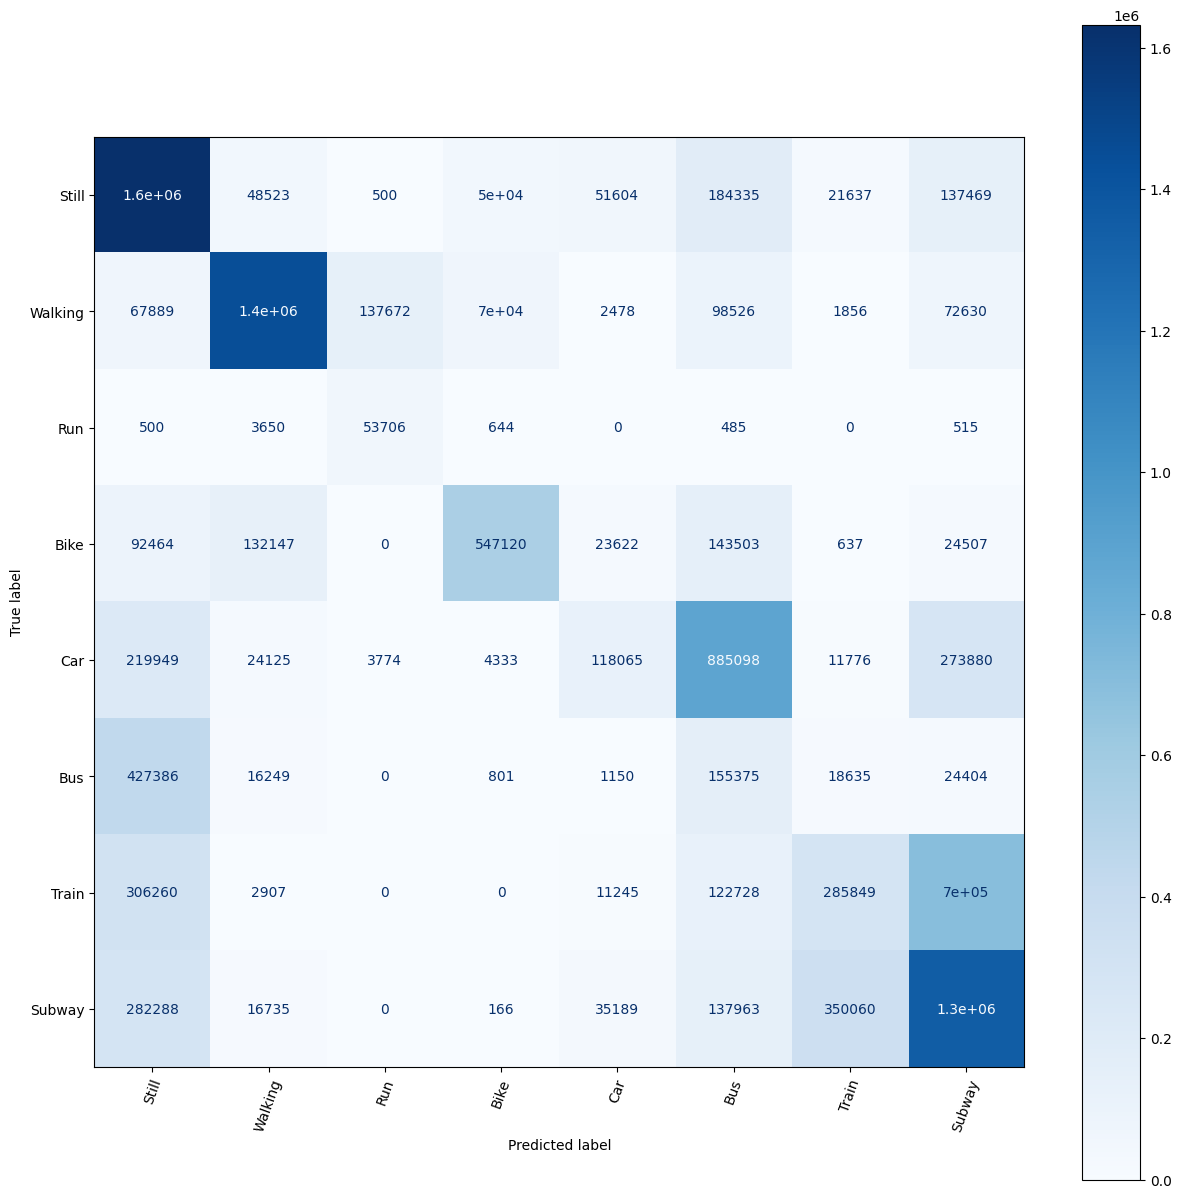

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))
cm = confusion_matrix(
    CLASS_LABELS[y_test.reshape(-1)],
    CLASS_LABELS[full_predictions.reshape(-1)],
    labels=CLASS_LABELS,
)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=CLASS_LABELS
).plot(cmap="Blues", xticks_rotation=70, ax=ax)

print(
    classification_report(
        CLASS_LABELS[y_test.reshape(-1)],
        CLASS_LABELS[full_predictions.reshape(-1)],
        labels=CLASS_LABELS,
        digits=3,
    )
)


In [26]:
np.save('../output/model/transformer/0601/pred-0015.npy',full_predictions)

## Profiler

In [24]:
@tf.function
def xy():
    out, attn = model(X_test[0])

# You can also do that in Python API.
tf.compat.v1.profiler.profile(
    xy.get_concrete_function().graph,
    options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation())


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


name: "_TFProfRoot"
children {
  name: "transformer/encoder/dense_1/Tensordot/MatMul"
  float_ops: 32768000
  total_float_ops: 32768000
  input_shapes {
    key: 0
    value {
      dim {
        size: 500
      }
      dim {
        size: 128
      }
    }
  }
  input_shapes {
    key: 1
    value {
      dim {
        size: 128
      }
      dim {
        size: 256
      }
    }
  }
  total_definition_count: 1
}
children {
  name: "transformer/encoder/dense_2/Tensordot/MatMul"
  float_ops: 32768000
  total_float_ops: 32768000
  input_shapes {
    key: 0
    value {
      dim {
        size: 500
      }
      dim {
        size: 256
      }
    }
  }
  input_shapes {
    key: 1
    value {
      dim {
        size: 256
      }
      dim {
        size: 128
      }
    }
  }
  total_definition_count: 1
}
children {
  name: "transformer/encoder_1/dense_3/Tensordot/MatMul"
  float_ops: 32768000
  total_float_ops: 32768000
  input_shapes {
    key: 0
    value {
      dim {
        size: 